In [1]:
import os
import load_dataset
import torch.nn as nn
import clip
import torch
import pyarrow as pa
import lancedb
import random
import json
import pinecone
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from IPython.display import display
from dotenv import dotenv_values


device = "cuda" if torch.cuda.is_available() else "cpu"
_, preprocess = clip.load("ViT-B/32", device=device)

os.environ['EXTRACT_DIR'] = "/tmp/GLAMI-1M/"
load_dataset.download_dataset(dataset_url="https://huggingface.co/datasets/glami/glami-1m/resolve/main/GLAMI-1M-dataset--test-only.zip")

config = dotenv_values('../database/.env')
api_key = config['API_KEY']

Dataset sub directory already exists in the extract dir. Delete it to re-download.


In [2]:
# load pretrained model
model = torch.load('model_storage/pretrained_clip.pt')

In [3]:
df = load_dataset.get_dataframe('test')[['category_name', 'image_file']]
df = df.drop_duplicates(subset=['image_file'])[['category_name', 'image_file']].reset_index(drop=True)

### Connect to pinecone vector database

In [4]:
pinecone.init(      
    api_key=api_key,      
    environment='us-west1-gcp'      
)      

index = pinecone.Index('fashion')

In [5]:
def image2embs(image_query):
    image = preprocess(Image.open(image_query).convert('RGB')).unsqueeze(0).to(device)
    embs = model.encode_image(image)
    return embs.detach().cpu().numpy()[0].tolist()

def text2emb(text_query):
    text_token = clip.tokenize(text_query)
    text_emb = model.encode_text(text_token.to(device))
    return text_emb.detach().cpu().numpy()[0].tolist()

def search(input_emb, top_k):
    matching = index.query(vector=input_emb, top_k=top_k, include_values=True)['matches']
    match_ids = [match_id['id'] for match_id in matching]
    return match_ids[1: ]

def display_top_similarity(query):
    try:
        emb = image2embs(query)
    except:
        emb = text2emb(query)
    
    match_ids = search(emb, 10)
    for i in map(int, match_ids):
        display(Image.open(df.image_file[i]).convert('RGB'))

### Image query

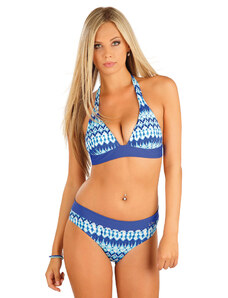

In [6]:
# image from database
Image.open(df.image_file[6437])

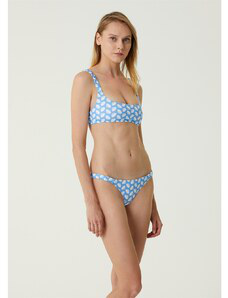

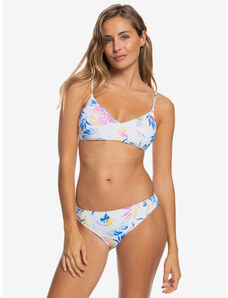

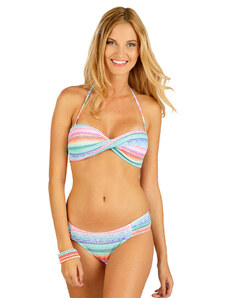

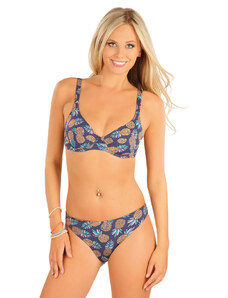

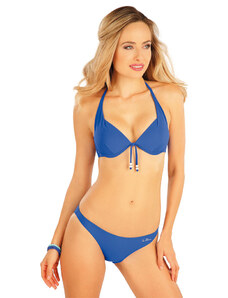

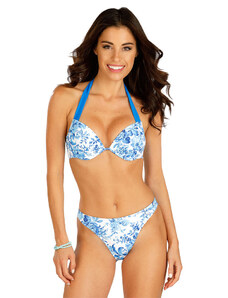

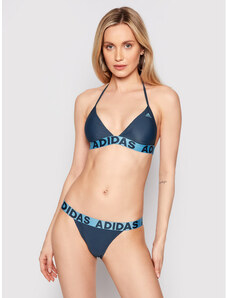

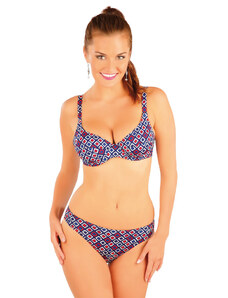

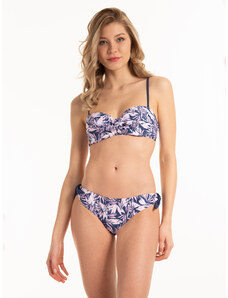

In [7]:
images_query = df.image_file[6437]
display_top_similarity(images_query)

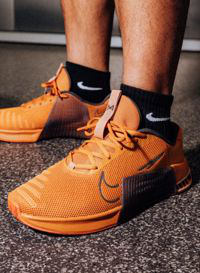

In [8]:
# image from user
user_image = 'data/men-s-shoes-clothing-accessories.jpg'
Image.open(user_image).convert('RGB')

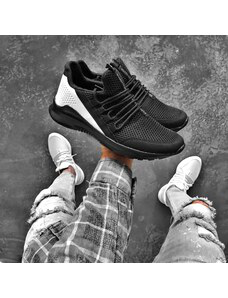

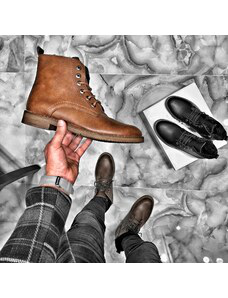

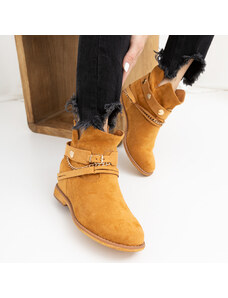

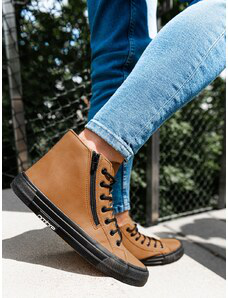

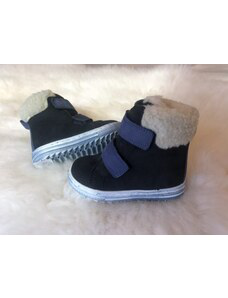

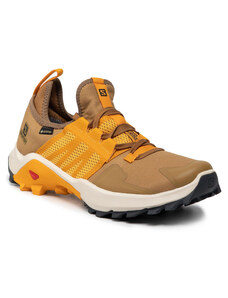

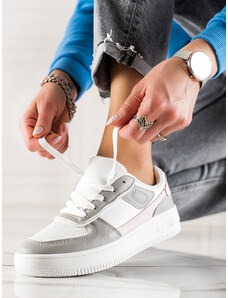

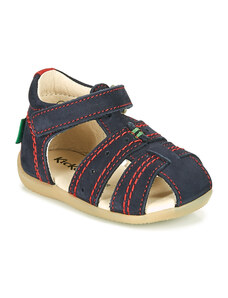

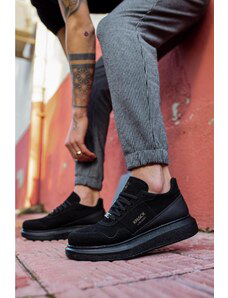

In [9]:
display_top_similarity(user_image)

### Text query

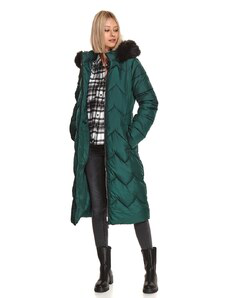

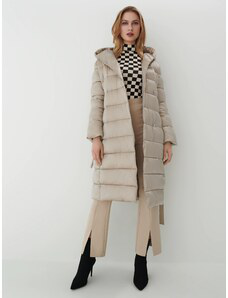

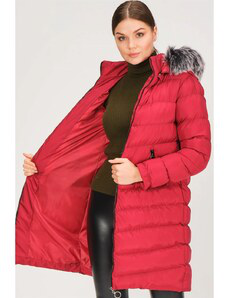

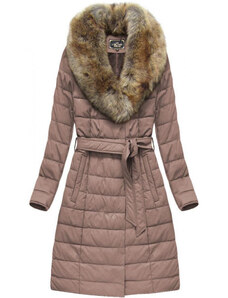

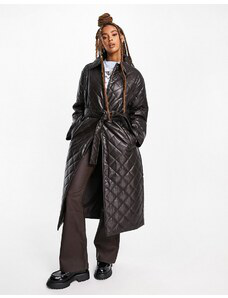

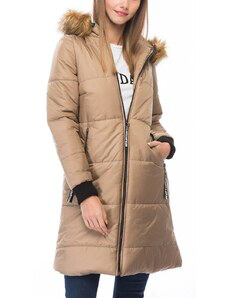

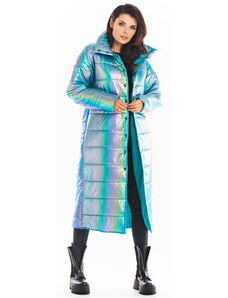

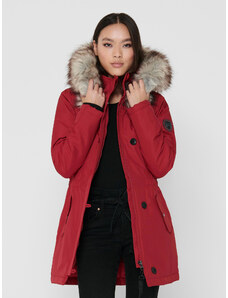

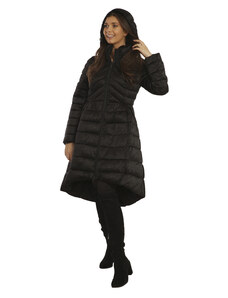

In [10]:
text_query = 'women coat'
display_top_similarity(text_query)

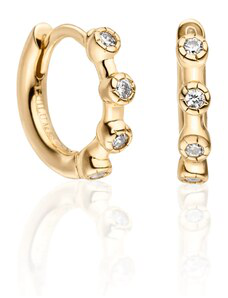

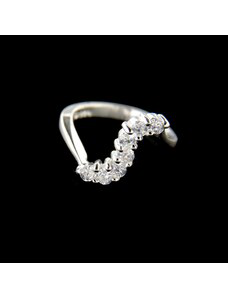

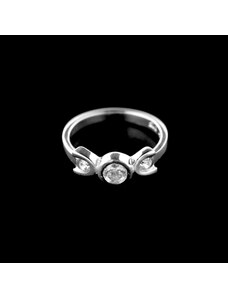

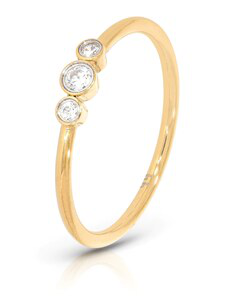

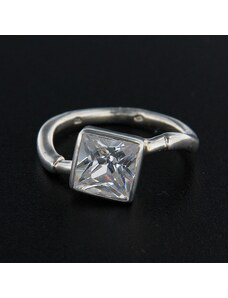

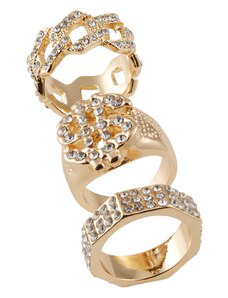

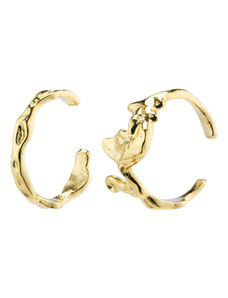

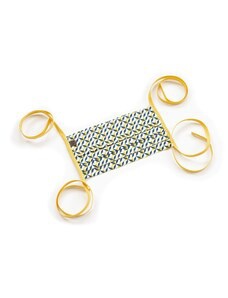

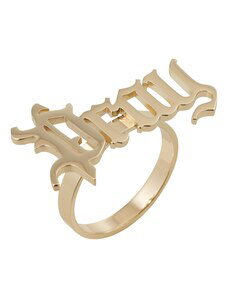

In [11]:
text_query = 'jewelry ring'
display_top_similarity(text_query)

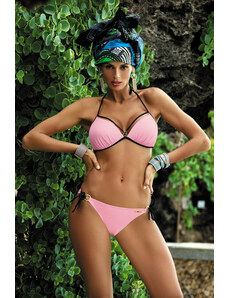

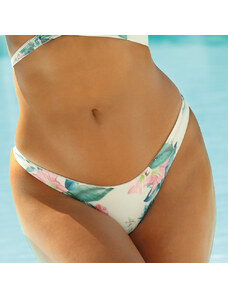

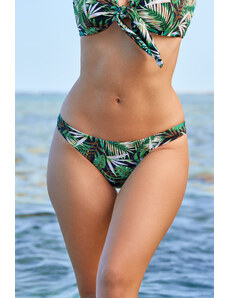

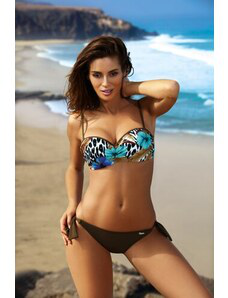

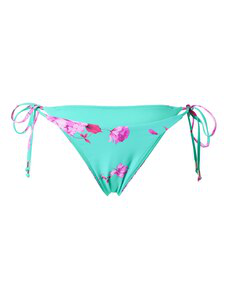

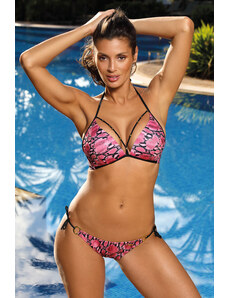

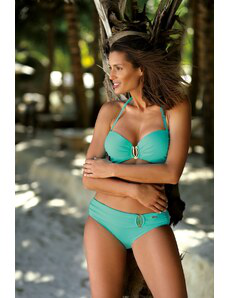

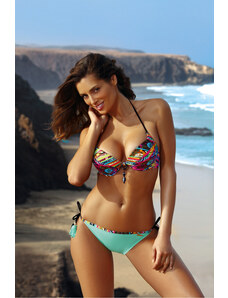

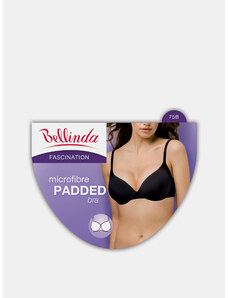

In [13]:
text_query = 'bikini'
display_top_similarity(text_query)